In [27]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/raw/train.csv')
train.columns = ['abv', 'company', 'food', 'glassware', 'id', 'number_ratings', 'style', 'cell_temp', 'serving_temp', 'score']
train.head()

,abv,company,food,glassware,id,number_ratings,style,cell_temp,serving_temp,score
0,6.5,8929,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",15121,22,AmericanIPA,40-45,45-50,3.28
1,5.5,13187,"(PanAsian)Cheese(earthyCamembert,Fontina,nutty...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",59817,1,AmericanPaleAle(APA),35-40,40-45,3.52
2,8.1,6834,"Meat(Pork,Poultry)","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",32669,3,IrishRedAle,35-40,40-45,4.01
3,NaN,11688,"(Indian,LatinAmerican,PanAsian)General(Aperitif)","PintGlass(orBecker,Nonic,Tumbler),PilsenerGlas...",130798,0,AmericanMaltLiquor,35-40,35-40,0.00
4,6.0,10417,"Meat(Poultry,Fish,Shellfish)",PilsenerGlass(orPokal),124087,1,EuroPaleLager,35-40,40-45,2.73


## Data Preprocessing

### Handling Empty Values

In [3]:
print(train.shape)
train.isnull().sum()

(185643, 10)


abv               15130
company               0
food                  0
glassware             0
id                    0
number_ratings        0
style                 0
cell_temp          6781
serving_temp        193
score                 0
dtype: int64

<h4>Currently using a simple strategy to interploate empty values</h4>
<p> 1. Substitute average for ABV </p>
<p> 2. Most frequent cellar temperature </p>
<p> 3. Most frequent serving temperature </p>

In [4]:
print(train.abv.mean())
train.abv[train.abv.isnull()] = train.abv.mean()

6.35496073613


In [5]:
print(train.serving_temp.value_counts().idxmax())
train.serving_temp[train.serving_temp.isnull()] = train.serving_temp.value_counts().idxmax()

45-50


In [6]:
print(train.cell_temp.value_counts().idxmax())
train.cell_temp[train.cell_temp.isnull()] = train.cell_temp.value_counts().idxmax()

40-45


In [7]:
temp_encoder = LabelEncoder()
temp_encoder.fit(train.serving_temp)
train.serving_temp = temp_encoder.transform(train.serving_temp)
train.cell_temp = temp_encoder.transform(train.cell_temp)

In [8]:
#style_encoder = LabelEncoder()
#style_encoder.fit(train.style)
#len(train['style'].value_counts())

In [9]:
# The number_ratings feature is in text because some of the rows are like '1,000'
# Remove ','
train.number_ratings = train.number_ratings.apply(lambda x: x.replace(",", ""))
train.number_ratings = pd.to_numeric(train.number_ratings)

In [10]:
# Processing the food and glassware features
# Remove eveyything between parantheses
train['food'] = train.food.str.replace(r"\(.*\)","")
train['glassware'] = train.glassware.str.replace(r"\(.*\)","")

In [11]:
train_glass = train.glassware.str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)
train_glass.columns = ['glass_' + str(col).lower()  for col in train_glass.columns]
train_glass.head()

,glass_flute,glass_goblet,glass_mug,glass_none,glass_oversizedwineglass,glass_pilsenerglass,glass_pintglass,glass_snifter,glass_stange,glass_tulip,glass_weizenglass,glass_yet
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0


In [12]:
train_food = train.food.str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)
train_food.columns = ['food_' + str(col).lower()  for col in train_food.columns]
train_food.head()

,food_cheese,food_meat,food_none,food_yet
0,0,0,0,0
1,0,0,0,0
2,0,1,0,0
3,0,0,0,0
4,0,1,0,0


In [13]:
# Combine all the dataframes
train_final = pd.concat([train, train_food, train_glass], axis=1)
train_final.drop(['food', 'glassware'], axis=1, inplace=True)
train_final.head()

,abv,company,id,number_ratings,style,cell_temp,serving_temp,score,food_cheese,food_meat,...,glass_mug,glass_none,glass_oversizedwineglass,glass_pilsenerglass,glass_pintglass,glass_snifter,glass_stange,glass_tulip,glass_weizenglass,glass_yet
0,6.500000,8929,15121,22,AmericanIPA,1,2,3.28,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5.500000,13187,59817,1,AmericanPaleAle(APA),0,1,3.52,0,0,...,0,0,0,0,1,0,0,0,0,0
2,8.100000,6834,32669,3,IrishRedAle,0,1,4.01,0,1,...,0,0,0,0,1,0,0,0,0,0
3,6.354961,11688,130798,0,AmericanMaltLiquor,0,0,0.00,0,0,...,0,0,0,0,1,0,0,0,0,0
4,6.000000,10417,124087,1,EuroPaleLager,0,1,2.73,0,1,...,0,0,0,1,0,0,0,0,0,0


# Exploratory Analysis

### Univariate Analysis 

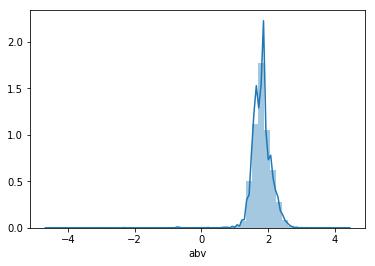

In [14]:
#Using the original dataframe for visualizations
sns.distplot(np.log(train.abv))

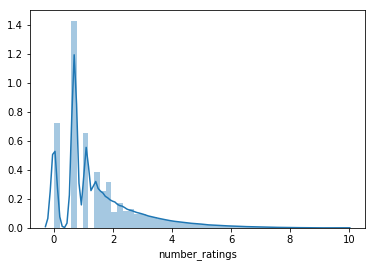

In [15]:
sns.distplot(np.log(train.number_ratings + 1))

##### Target Variable

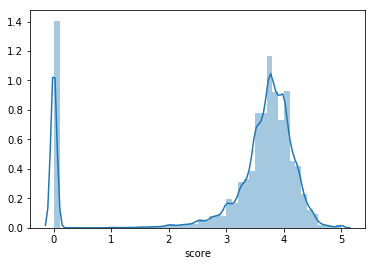

In [16]:
sns.distplot(train.score)

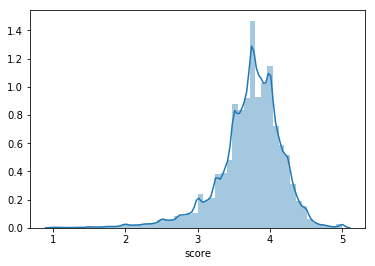

In [17]:
sns.distplot(train.score[train.number_ratings > 0])

### Correlation Analysis

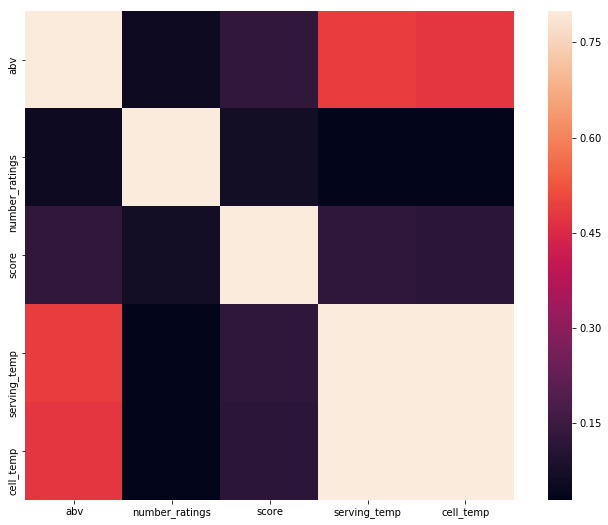

In [18]:
#correlation matrix
numeric_cols = ['abv', 'number_ratings', 'score', 'serving_temp', 'cell_temp']
corrmat = train[numeric_cols].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

<h2>Insights from Initial Exploration of Data</h2>
<h4> Target Variable </h4>
<p> 1. Those rows which have zero ratings have zero score. It'll be better to model values with ratings greater than zero and handle the zero values otherwise</p>
<p> 2. Score is almost normally distributed

<h4> Independent Variable </h4>
<p> 1. </p>

<h4> Correlation Analysis </h4>
Except serving temperature and cell temperature, There is no significant correlation between numeric features, hence linear, lasso etc can be used

# Model Training

In [19]:
# Remove columns which wont be used for traini
remove_cols = ['id', 'company', 'style']
train_final = train_final.drop(remove_cols, axis=1)

In [20]:
# Remove rows with 0 score
train_final = train_final[train_final.number_ratings > 0]
train_final_x = train_final.drop('score', axis=1)
train_final_y = train_final.score

In [21]:
train_x, valid_x, train_y, valid_y = train_test_split(train_final_x, 
                                                      train_final_y, 
                                                      test_size=0.3)

## Linear methods

In [22]:
lreg_model = LinearRegression()
lreg_model.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluation

In [28]:
def rmse(y_pred, y_actual):
    return sqrt(mean_squared_error(y_actual, y_pred))

def evaluate_model(model, valid_x, valid_y):
    r2_score = model.score(valid_x, valid_y)
    print("R2 value:" + str(r2_score))
    valid_preds = model.predict(valid_x)
    print("RMSE Value:" + str(rmse(valid_preds, valid_y)))

In [30]:
# Evaluation of Linear model
evaluate_model(lreg_model, valid_x, valid_y)

R2 value:0.168122688945
RMSE Value:0.408254827192
